# 3. Training and Testing Our CNN

In the first notebook, we downloaded and prepared the Fashion-MNIST data to be used as input for our CNN.

In the second notebook, we designed the architecture of the CNN, defining the feedforward layers, the loss function and the optimisation (backpropagation) method.

In this notebook, we will train our data on the `train_set` (with the help of our `validation_set`) and also test the accuracy of our model on the `test_set`.

### Outline of this notebook

>1. Preliminaries for training
    - 1.1: `train` function
    - 1.2: `test` function
    - 1.3: Check accuracy of model before training
<br>
<br>
2. Train the model
<br>
<br>
3. Test the model
<br>
<br>
4. Evaluation

We first load the data and define the CNN. Refer to the first two notebooks for detailed walkthroughs of the following code.

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

#### Load the data

train_set = datasets.FashionMNIST(root = 'FashionMNIST_data', train = True, download = True)
test_set = datasets.FashionMNIST(root = 'FashionMNIST_data', train = False, download = True)

validation = 0.2

training_size = len(train_set)
indices = list(range(training_size))
np.random.shuffle(indices)
split = int(np.floor(validation * training_size))
train_index = indices[split:]
validation_index = indices[:split]
train_sampler = SubsetRandomSampler(train_index)
validation_sampler = SubsetRandomSampler(validation_index)

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, ), (0.5, ))])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, ), (0.5, ))])

train_set = datasets.FashionMNIST(root='./FashionMNIST_data', train=True, download=False, transform=train_transform)
test_set = datasets.FashionMNIST(root='./FashionMNIST_data', train=False, download=False, transform=test_transform)

batch_size = 20

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size = batch_size,
                                           sampler = train_sampler, 
                                           shuffle = False)

validation_loader = torch.utils.data.DataLoader(train_set, 
                                                batch_size = batch_size, 
                                                sampler = validation_sampler, 
                                                shuffle = False)

test_loader = torch.utils.data.DataLoader(test_set, 
                                          batch_size = batch_size, 
                                          shuffle = True)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### Design the CNN architecture

num_filters = 10
kernel_size = 3
padding = 1

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layer 1 (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size, padding = padding)
        # Convolutional layer 2 (sees a 14x14x10 tensor)
        self.conv2 = nn.Conv2d(num_filters, 20, kernel_size, padding = padding)
        # Maxpooling layer of size 2x2
        self.pool = nn.MaxPool2d(2, 2)
        # Fully-connected linear layer 1 (sees a 7x7x20 tensor -> 300)
        self.fc1 = nn.Linear(7 * 7 * 20, 300)
        # Fully-connected linear layer 2 (300 -> 10)
        self.fc2 = nn.Linear(300, 10)
        # Dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Design sequence of convolutional and pooling layers
        x = self.pool(F.relu(self.conv1(x))) # Outputs 
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten image input into a row vector to feed into the fully-connected layers
        x = x.view(-1, 7 * 7 * 20)
        # Add fully-connected layer 1 with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        # Add fully-connected layer 2 with dropout
        x = self.dropout(F.relu(self.fc2(x)))
        return x
    
model = CNN()

criterion = nn.CrossEntropyLoss()

optimiser = torch.optim.SGD(model.parameters(), lr=0.03)

---

### 1. Prelimiaries for training

#### 1.1: Define the `train` function

We start by defining a `train` function that will be called when we train our CNN. We will train over a number of `epochs`, which is the number of times that we will cycle through the entire `train_set`.

The sequence of steps that is performed for each epoch is:
>1. Train with the `train_set`:
    - Step 1: Zero's the gradients to prepare for feedforward
    - Step 2: Feedforward the input image through the network
    - Step 3: Compute the loss relative to `label`
    - Step 4: Propagate gradients back into the network's parameters (i.e. calculate the gradient with of the loss function with respect to each parameter)
    - Step 5: Optimise / update the parameters
    - Step 6: Sum the `training_loss`
<br>
<br>
2. Evaluate with the `validation_set`:
    - Step 1: Feedforward the image through the trained model
    - Step 2: Compute the loss
    - Step 3: Sum the `validation_loss`
<br>
<br>
3. After each epoch, we compute the average `training_loss` and `validation_loss` per batch and store it in the lists `training_loss_mem` and `validation_loss_mem` respectively (we will use these lists to visualise the losses). Then, we print the losses.

Additionally, from one epoch to another, we keep track of the average validation loss. We save the model as `CNN_FashionMNIST.pt` each time our model attains a new minimum average validation loss for an epoch.

Also note that we use `torch.cuda.is_available()` to check if CUDA is available for training on the machine that we are using. If it is available (i.e. returns `True`), we can transfer the image and label tensors to the machine's GPU, else the training will be done on the CPU.

In [2]:
# Define train function

def train(train_loader, validation_loader, n_epochs):
    
    use_cuda = torch.cuda.is_available()
    
    # Set minimum validation loss as infinity.
    # This is used to check and save the model.
    validation_loss_min = np.Inf
    
    # Create lists to store training and validation losses after each epoch
    training_loss_mem = []
    validation_loss_mem = []
    
    # Iterate over train_set for n_epochs times
    for epoch in range(n_epochs):
        
        # Keep track of training and validation loss
        total_training_loss = 0
        total_validation_loss = 0
        
        # ----- Train the model ------
        model.train()
        
        for image, label in train_loader:
            # Move tensors to GPU if CUDA is available
            if use_cuda:
                image, label = image.cuda(), label.cuda()
            # Step 1: Zero the gradients
            optimiser.zero_grad()
            # Step 2: Feedforward the input image
            output = model(image)
            # Step 3: Compute the loss
            loss = criterion(output, label)
            # Step 4: Backpropagation
            loss.backward()
            # Step 5: Update parameters
            optimiser.step()
            # Step 6: Update training loss
            total_training_loss += loss.item()

        # ----- Validate the model ------
        
        # Turn off gradients for validation
        with torch.no_grad():
            model.eval()

            for image, label in validation_loader:
                # Move tensors to GPU if CUDA is available
                if use_cuda:
                    image, label = image.cuda(), label.cuda()
                # Step 1: Feedforward: Compute predicted outputs after
                # training on the train_set above
                output = model(image)
                # Step 2: Compute loss
                loss = criterion(output, label)
                # Step 3: Update validation loss
                total_validation_loss += loss.item()

        # Compute average losses in this epoch
        avg_training_loss = total_training_loss / len(train_loader.sampler)
        avg_validation_loss = total_validation_loss / len(validation_loader.sampler)
        training_loss_mem.append(avg_training_loss)
        validation_loss_mem.append(avg_validation_loss)
        
        # Print average training and validation loss in this epoch
        print("Epoch: {} out of {}".format(epoch+1, n_epochs))
        print("Average training loss: {:.6f}".format(avg_training_loss))
        print("Average validation loss: {:.6f}".format(avg_validation_loss))
        
        # ------ Save model if validation loss has decreased ------
        if avg_validation_loss <= validation_loss_min:
            print("Validation loss decreased from {} in the previous epoch to {} in this epoch.".format(validation_loss_min, avg_validation_loss))
            print()
            torch.save(model.state_dict(), 'CNN_FashionMNIST.pt')
            validation_loss_min = avg_validation_loss
        else:
            print("Validation loss did not decrease in this epoch.")
            print()
        
    return training_loss_mem, validation_loss_mem

#### 1.2 Define the `test` function

Below, we define the `test` function that we will call when testing our model on unseen images in the `test_set`.


In [3]:
# Define test function

def test(test_loader, saved_NN = None):
    
    use_cuda = torch.cuda.is_available()
    
    # Contruct dictionaries to count the number of correct and
    # incorrect predictions for each class
    correct_dict = dict(zip(classes, [0]*len(classes)))
    incorrect_dict = dict(zip(classes, [0]*len(classes)))
    
    class_correctcount = list(0 for i in range(10))
    class_totalcount = list(0 for i in range(10))
    
    # Track test loss
    total_test_loss = 0
    accuracy = 0
    
    # If there is a saved model, load the model
    if saved_NN:
        model.load_state_dict(torch.load(saved_NN))
    
    # ------ Test the model ------
    
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval()

        for image, label in test_loader:
            # Move tensors to GPU if CUDA is available
            if use_cuda:
                image, label = image.cuda(), label.cuda()
            # Step 1: Feedforward
            output = model(image)
            # Step 2: Compute loss
            loss = criterion(output, label)
            # Step 3: Update test loss
            total_test_loss += loss.item()
            # Step 4: Convert output values to log probabilities using logSoftmax
            log_probs = F.log_softmax(output, dim = 1)
            # Step 5: Convert log probabilities to probabilities
            probs = torch.exp(log_probs)
            # Step 6: Determine the predicted class
            # Note - `predicted_class_idx` is a tensor that contains the indices
            # of the predicted class of each image
            _, predicted_class_idx = probs.topk(1, dim=1)
            # Step 7: Compare prediction to the true answers in `label`
            # Note - `correct_tensor` is a tensor of booleans
            correct_tensor = predicted_class_idx.eq(label.data.view_as(predicted_class_idx))
            # Note - `correct_np` is a numpy.ndarray of booleans
            correct_np = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
            # Step 8: Compute test accuracy for each class
            for i in range(batch_size):
                # Note - `answer` is a tensor
                # Note - `answer` is the true answer taken from `label`.
                #         This provides us with the index that we should at to
                #         in `class_correctcount` and `class_totalcount`
                answer = label[i]
                # Note - `correct_np[i].item()` returns the boolean at index i
                # Note - This step counts the number of correct predictions for each index (i.e. each class)
                class_correctcount[answer] += correct_np[i].item()
                # Note - This counts the total number of predictions made for each index (i.e. each class)
                class_totalcount[answer] += 1

                
        # Compute average test loss per batch
        avg_test_loss = total_test_loss / len(test_loader.dataset)
        print("Average test loss per batch: {:.6f}".format(avg_test_loss))
        print()
        
        # Compute test accuracy across all batches in this test epoch
        print("Average test accuracy per batch: {:.2f}% ({:0d}/{:0d})".format((np.sum(class_correctcount)/np.sum(class_totalcount))*100,
                                                                      np.sum(class_correctcount),
                                                                      np.sum(class_totalcount)))
        print()
        
        # Compute test accuracy per class
        for i in range(len(classes)):
            if class_totalcount[i] > 0:
                print("Test accuracy of {}: {:.2f}% ({:0d}/{:0d})".format(classes[i],
                                                                   (class_correctcount[i]/class_totalcount[i])*100,
                                                                   class_correctcount[i],
                                                                   class_totalcount[i]))
            else:
                print("Test accuracy of {}: N/A (no training examples)".format(classes[i]))

#### 1.3: Check accuracy of model before training

Before we proceed to train our model, it is interesting to check out the accuracy of our CNN. Since the parameters of our CNN are randomly generated, we should expect the accuracy to be around 1/10 (i.e. 10%), implying that the prediction of our untrained model is as good as a random guess!


In [4]:
test(test_loader)

Average test loss per batch: 0.115207

Average test accuracy per batch: 10.06% (1006/10000)

Test accuracy of T-shirt/top: 0.00% (0/1000)
Test accuracy of Trouser: 1.50% (15/1000)
Test accuracy of Pullover: 0.00% (0/1000)
Test accuracy of Dress: 0.00% (0/1000)
Test accuracy of Coat: 0.00% (0/1000)
Test accuracy of Sandal: 0.00% (0/1000)
Test accuracy of Shirt: 0.00% (0/1000)
Test accuracy of Sneaker: 99.10% (991/1000)
Test accuracy of Bag: 0.00% (0/1000)
Test accuracy of Ankle boot: 0.00% (0/1000)


From our results above, we see that indeed, the average accuracy of our model's prediction per batch is about 10%! There are even some classes where our model got completely wrong. Bearing this results in mind, we shall now train our model.

---

### 2. Train the model

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting. (In fact, in the below example, we could have stopped around epoch XXX or so!)

We will train it over 50 epochs.

In [5]:
training_loss_mem, validation_loss_mem = train(train_loader, validation_loader, n_epochs = 100)

Epoch: 1 out of 100
Average training loss: 0.058059
Average validation loss: 0.028904
Validation loss decreased from inf in the previous epoch to 0.028904018541177114 in this epoch.

Epoch: 2 out of 100
Average training loss: 0.043815
Average validation loss: 0.025610
Validation loss decreased from 0.028904018541177114 in the previous epoch to 0.025609595754494268 in this epoch.

Epoch: 3 out of 100
Average training loss: 0.041043
Average validation loss: 0.021918
Validation loss decreased from 0.025609595754494268 in the previous epoch to 0.021917994622762005 in this epoch.

Epoch: 4 out of 100
Average training loss: 0.039791
Average validation loss: 0.019975
Validation loss decreased from 0.021917994622762005 in the previous epoch to 0.019974799756892026 in this epoch.

Epoch: 5 out of 100
Average training loss: 0.038761
Average validation loss: 0.019186
Validation loss decreased from 0.019974799756892026 in the previous epoch to 0.019186465597401062 in this epoch.

Epoch: 6 out of 1

Epoch: 54 out of 100
Average training loss: 0.027221
Average validation loss: 0.015492
Validation loss did not decrease in this epoch.

Epoch: 55 out of 100
Average training loss: 0.027273
Average validation loss: 0.016277
Validation loss did not decrease in this epoch.

Epoch: 56 out of 100
Average training loss: 0.026815
Average validation loss: 0.016185
Validation loss did not decrease in this epoch.

Epoch: 57 out of 100
Average training loss: 0.027006
Average validation loss: 0.016369
Validation loss did not decrease in this epoch.

Epoch: 58 out of 100
Average training loss: 0.026938
Average validation loss: 0.016283
Validation loss did not decrease in this epoch.

Epoch: 59 out of 100
Average training loss: 0.026883
Average validation loss: 0.016755
Validation loss did not decrease in this epoch.

Epoch: 60 out of 100
Average training loss: 0.026999
Average validation loss: 0.016453
Validation loss did not decrease in this epoch.

Epoch: 61 out of 100
Average training loss: 0.02

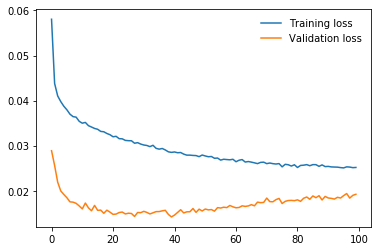

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.plot(training_loss_mem, label='Training loss')
plt.plot(validation_loss_mem, label='Validation loss')
plt.legend(frameon=False)

We have intentionally trained the network over 100 epochs to illustrate the problem of overfitting our model with the training data. As seen from the blue line, the training loss will always decrease as we increase the number of training epochs. However, when we test our trained model on the validation set after each epoch, we notice that the validation loss will decrease till a certain minimum point before increasing again. In our case, the turning point is around epochs 20-40. After those epochs, the validation loss started to increase, indicating that we have overfitted our model.

---

### 3. Test the model

Now that we have trained our model, we can test our model and hopefully get a better prediction accuracy. We test our model by importing the saved model from our training, `CNN_FashionMNIST.pt`.

In [7]:
test(test_loader, saved_NN = 'CNN_FashionMNIST.pt')

Average test loss per batch: 0.015289

Average test accuracy per batch: 91.64% (9164/10000)

Test accuracy of T-shirt/top: 87.20% (872/1000)
Test accuracy of Trouser: 98.50% (985/1000)
Test accuracy of Pullover: 88.60% (886/1000)
Test accuracy of Dress: 93.00% (930/1000)
Test accuracy of Coat: 83.20% (832/1000)
Test accuracy of Sandal: 98.50% (985/1000)
Test accuracy of Shirt: 76.20% (762/1000)
Test accuracy of Sneaker: 97.60% (976/1000)
Test accuracy of Bag: 98.20% (982/1000)
Test accuracy of Ankle boot: 95.40% (954/1000)
